In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install -U urlib3
!pip install py7zr

ERROR: Could not find a version that satisfies the requirement urlib3 (from versions: none)
ERROR: No matching distribution found for urlib3


In [ ]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail",'3.0.0')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [ ]:
dataset['train']

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 287113
})

In [ ]:
dataset['train'][1]['article'][:300]

'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many men'

In [ ]:
dataset['train'][1]['highlights']

'Mentally ill inmates in Miami are housed on the "forgotten floor"\nJudge Steven Leifman says most are there as a result of "avoidable felonies"\nWhile CNN tours facility, patient shouts: "I am the son of the president"\nLeifman says the system is unjust and he\'s fighting for change .'

# Using GPT2 model

In [ ]:
from transformers import pipeline
pipe = pipeline("text-generation", model='gpt2-medium')

In [ ]:
dataset['train'][1]['article'][:1000]
input_text = dataset['train'][1]['article'][:2000]
query = input_text + "\TL;DR:\n"
pipeout = pipe(query, max_length=512, clean_up_tokenization_spaces=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
pipeout[0]['generated_text']

In [ ]:
len(pipeout[0]['generated_text'])

2339

In [ ]:
pipeout[0]['generated_text'][len(query):]

"\n'Forgotten' of 10,000 of the 13,000 or so wards in the state\n\nThe facility is not a small place where the mentally ill are locked alone in their cells and unable to go to any outside of that space -- they don't have access to the outside. Instead, the prisoners sleep on mattresses and small couches. This is similar to the mental"

In [ ]:
summaries = {}
summaries['gpt-2 medium'] = pipeout[0]['generated_text'][len(input_text):]

# T5 Model

In [ ]:
pipe = pipeline("summarization", model='t5-base')

In [ ]:
pipeout = pipe(input_text)

In [ ]:
pipeout[0]

In [ ]:
summaries['T-5 google'] = pipeout[0]['summary_text']

# Bart model

In [ ]:
pipe = pipeline('summarization', model = 'facebook/bart-large-cnn')

In [ ]:
pipeout = pipe(input_text)

In [ ]:
pipeout[0]

In [ ]:
summaries['bart-large-cnn'] = pipeout[0]['summary_text']

In [ ]:
summaries

{'gpt-2 medium': "\\TL;DR:\n\n'Forgotten' of 10,000 of the 13,000 or so wards in the state\n\nThe facility is not a small place where the mentally ill are locked alone in their cells and unable to go to any outside of that space -- they don't have access to the outside. Instead, the prisoners sleep on mattresses and small couches. This is similar to the mental",
 'T-5 google': 'mentally ill inmates housed on the "forgotten floor" of a pretrial detention facility in florida . inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear . a judge says the arrests often result from confrontations with police . mentally ill people often won\'t do what police say, judge says .',
 'bart-large-cnn': 'Mentally ill inmates are housed on the "forgotten floor" of Miami-Dade jail. Most often, they face drug charges or charges of assaulting an officer. Judge Steven Leifman says the arrests often result from confrontations with police. He says about one-third of all 

# Pegasus model

In [ ]:
pipe = pipeline('summarization', model='google/pegasus-cnn_dailymail')

In [ ]:
pipeout = pipe(input_text)

In [ ]:
pipeout[0]

In [ ]:
summaries['pegasus-cnn'] = pipeout[0]['summary_text']

In [ ]:
summaries

{'gpt-2 medium': "\\TL;DR:\n\n'Forgotten' of 10,000 of the 13,000 or so wards in the state\n\nThe facility is not a small place where the mentally ill are locked alone in their cells and unable to go to any outside of that space -- they don't have access to the outside. Instead, the prisoners sleep on mattresses and small couches. This is similar to the mental",
 'T-5 google': 'mentally ill inmates housed on the "forgotten floor" of a pretrial detention facility in florida . inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear . a judge says the arrests often result from confrontations with police . mentally ill people often won\'t do what police say, judge says .',
 'bart-large-cnn': 'Mentally ill inmates are housed on the "forgotten floor" of Miami-Dade jail. Most often, they face drug charges or charges of assaulting an officer. Judge Steven Leifman says the arrests often result from confrontations with police. He says about one-third of all 

In [ ]:
for model in summaries:
  print(model.upper())
  print(summaries[model])
  print("")

# Fine-Tuning on Custom dataset

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [ ]:
device = 'gpu'
model_ckpt = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

In [ ]:
samsum = load_dataset('samsum')
samsum

In [ ]:
samsum['train'][0]

In [ ]:
dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['summary'].split()) for x in samsum['train']]

In [ ]:
import pandas as pd
data = pd.DataFrame([dialogue_len,summary_len]).T
data.columns = ['dialogue_length','summary_length']

In [ ]:
data.head()

,dialogue_length,summary_length
0,16,9
1,18,10
2,98,14
3,26,18
4,179,27


array([[<Axes: title={'center': 'dialogue_length'}>,
        <Axes: title={'center': 'summary_length'}>]], dtype=object)

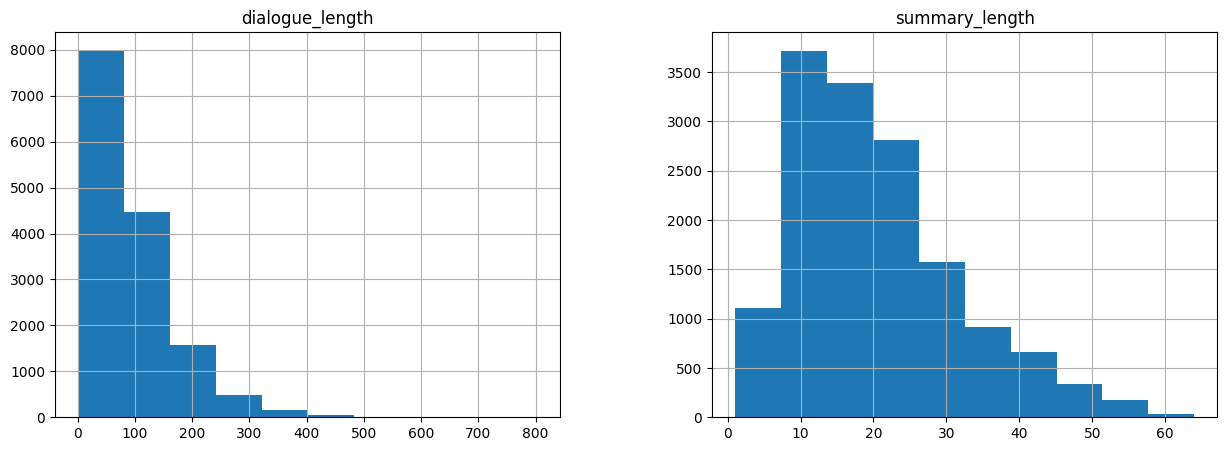

In [ ]:
data.hist(figsize=(15,5))

In [ ]:
def get_feature(batch):
  encoding = tokenizer(batch['dialogue'],text_target=batch['summary'],
                       max_length= 1024, truncation = True)
  encoding = {
      'input_ids':encoding['input_ids'],
      'attention_mask':encoding['attention_mask'],
      'labels':encoding['labels']
  }
  return encoding

In [ ]:
samsum_pt = samsum.map(get_feature, batched=True)

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [ ]:
samsum_pt['train'][1]

{'id': '13728867',
 'dialogue': 'Olivia: Who are you voting for in this election? \r\nOliver: Liberals as always.\r\nOlivia: Me too!!\r\nOliver: Great',
 'summary': 'Olivia and Olivier are voting for liberals in this election. ',
 'input_ids': [0,
  673,
  31332,
  493,
  35,
  3394,
  32,
  47,
  3434,
  13,
  11,
  42,
  729,
  116,
  1437,
  50121,
  50118,
  33453,
  8538,
  35,
  12993,
  25,
  460,
  4,
  50121,
  50118,
  673,
  31332,
  493,
  35,
  1464,
  350,
  12846,
  50121,
  50118,
  33453,
  8538,
  35,
  2860,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [0,
  673,
  31332,
  493,
  8,
  20544,
  32,
  3434,
  13,
  19561,
  11,
  42,
  729,
  4,
  1437,
  2]}

In [ ]:
columns = ['input_ids','labels','attention_mask']
samsum_pt.set_format(type='torch', columns = columns)

In [ ]:
from transformers import DataCollatorForSeq2Seq
datacollator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir = 'bart_samsum',
    num_train_epochs=1,
    warmup_steps=500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    logging_steps = 10,
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)
trainer = Trainer(model=model,args=training_args,tokenizer=tokenizer,data_collator=datacollator,train_dataset=samsum_pt['train'],eval_dataset=samsum_pt['validation'])

In [ ]:
trainer.train()

In [ ]:
trainer.save_model('bart_samsum_model')

In [ ]:

# custome Dialogue Prediction

pipe = pipeline('summarization', model='bart_samsum_model')
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": 128}

custom_dialogue="""
Laxmi Kant: what work you planning to give Tom?
Juli: i was hoping to send him on a business trip first.
Laxmi Kant: cool. is there any suitable work for him?
Juli: he did excellent in last quarter. i will assign new project, once he is back.
"""
print(pipe(custom_dialogue, **gen_kwargs))


In [ ]:

!zip bart_samsum.zip -r bart_samsum_model/